### **Importing Packages**

In [ ]:
!pip install sentence-transformers
!pip install faiss-gpu

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import csv
import pandas
import nltk
import numpy
import matplotlib
import seaborn
import string
import re
import os
import random
import time
import torch #should not import it if running on Kaggle with GPU, since kaggle automatically imports it and if I again import it generates cuda not found error
import pickle
import faiss
import warnings
import pprint

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, util
from tqdm import tqdm
from textblob import TextBlob
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch import nn

warnings.filterwarnings('ignore')

C:\Users\Siftullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siftullah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Siftullah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siftullah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **Data Loading and Preprocessing**

In [ ]:
dataset_path = "data/wikipedia_movies_plots.csv"
dataframe = pandas.read_csv(dataset_path)

dataframe

,title,url,text
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

dataframe['cleaned_text'] = dataframe['text'].apply(clean_text)
dataframe = dataframe.query("cleaned_text != ''")

dataframe

,title,url,text,cleaned_text
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...
...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...


In [ ]:
dataframe.loc[:, 'cleaned_text_length'] = dataframe['cleaned_text'].apply(lambda x: len(x.split()))
dataframe.describe()

,cleaned_text_length
count,34894.000000
mean,207.197169
std,172.862536
min,1.000000
25%,69.000000
50%,159.000000
75%,323.000000
max,3176.000000


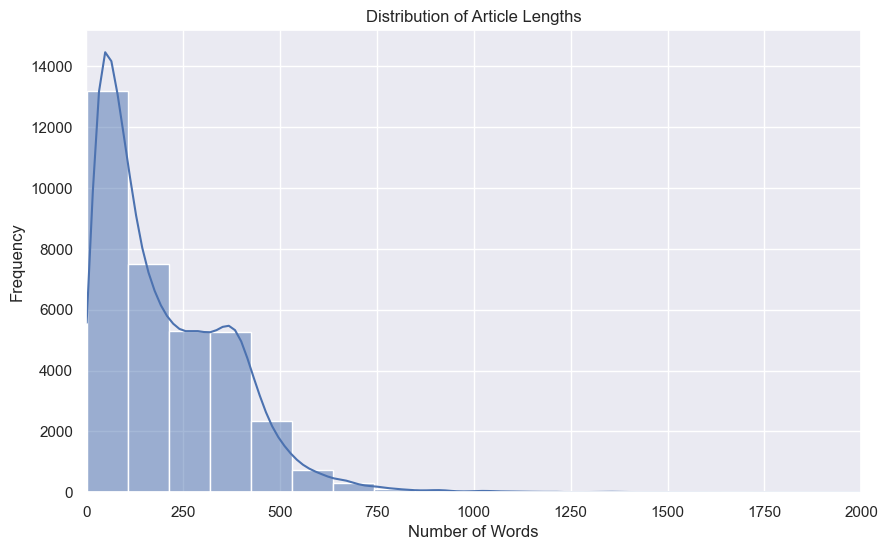

In [ ]:
seaborn.set_theme()
matplotlib.pyplot.figure(figsize=(10, 6))
seaborn.histplot(dataframe['cleaned_text_length'], bins=30, kde=True)
matplotlib.pyplot.title('Distribution of Article Lengths')
matplotlib.pyplot.xlabel('Number of Words')
matplotlib.pyplot.ylabel('Frequency')
matplotlib.pyplot.xlim(0, 2000)
matplotlib.pyplot.show()

In [ ]:
dataframe = dataframe.query("cleaned_text_length <= 512")
dataframe.describe()

,cleaned_text_length
count,33330.000000
mean,185.912061
std,137.776782
min,1.000000
25%,66.000000
50%,147.000000
75%,298.000000
max,512.000000


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33330 entries, 0 to 34893
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                33326 non-null  object
 1   url                  33326 non-null  object
 2   text                 33326 non-null  object
 3   cleaned_text         33330 non-null  object
 4   cleaned_text_length  33330 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
dataframe.dropna(inplace=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33326 entries, 0 to 34893
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                33326 non-null  object
 1   url                  33326 non-null  object
 2   text                 33326 non-null  object
 3   cleaned_text         33326 non-null  object
 4   cleaned_text_length  33326 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


### **Generating Embeddings Using TF-IDF**

In [ ]:
def get_tf_idf_embeddings(text):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    embedding = tfidf_matrix.toarray().flatten()
    return embedding

In [ ]:
pickle_file = 'data/tf_idf_embeddings.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as file:
        dataframe['tf_idf_embedding'] = pickle.load(file)
else:
    dataframe['tf_idf_embedding'] = dataframe['cleaned_text'].apply(get_tf_idf_embeddings)
    with open(pickle_file, 'wb') as file:
        pickle.dump(dataframe['tf_idf_embedding'].to_list(), file)

In [ ]:
dataframe

,title,url,text,cleaned_text,cleaned_text_length,tf_idf_embedding
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...,48,"[0.1336306209562122, 0.1336306209562122, 0.133..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...,44,"[0.14285714285714285, 0.14285714285714285, 0.1..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...,42,"[0.1543033499620919, 0.3086066999241838, 0.154..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...,85,"[0.0890870806374748, 0.0890870806374748, 0.267..."
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...,71,"[0.07980868844676221, 0.07980868844676221, 0.0..."
...,...,...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...,342,"[0.03087537605472192, 0.06175075210944384, 0.0..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...,7,"[0.4082482904638631, 0.4082482904638631, 0.408..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...,38,"[0.15075567228888181, 0.15075567228888181, 0.1..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...,110,"[0.09622504486493763, 0.09622504486493763, 0.0..."


### **Generating Embeddings using BERT**

In [ ]:
bert_tokenizer_path = "saved_models/bert_tokenizer"
bert_model_path = "saved_models/bert_model"

if not os.path.exists(bert_tokenizer_path):
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_tokenizer.save_pretrained(bert_tokenizer_path)
else:
    bert_tokenizer = BertTokenizer.from_pretrained(bert_tokenizer_path)

if not os.path.exists(bert_model_path):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.save_pretrained(bert_model_path)
else:
    bert_model = BertModel.from_pretrained(bert_model_path)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().cpu().numpy()

In [ ]:
pickle_file = 'data/bert_embeddings.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as file:
        dataframe['bert_embeddings'] = pickle.load(file)
else:
    dataframe['bert_embeddings'] = dataframe['cleaned_text'].apply(get_bert_embeddings)
    with open(pickle_file, 'wb') as file:
        pickle.dump(dataframe['bert_embeddings'].to_list(), file)

In [ ]:
dataframe

,title,url,text,cleaned_text,cleaned_text_length,tf_idf_embedding,bert_embeddings
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...,48,"[0.1336306209562122, 0.1336306209562122, 0.133...","[0.108548015, 0.51431626, 0.37518013, -0.29468..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...,44,"[0.14285714285714285, 0.14285714285714285, 0.1...","[0.18130904, -0.26999384, 0.7727826, -0.195408..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...,42,"[0.1543033499620919, 0.3086066999241838, 0.154...","[-0.1220507, 0.15358531, 0.34124604, 0.0239120..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...,85,"[0.0890870806374748, 0.0890870806374748, 0.267...","[-0.0005573636, 0.32940993, 0.39858818, -0.138..."
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...,71,"[0.07980868844676221, 0.07980868844676221, 0.0...","[0.047225162, 0.37801903, 0.39852342, -0.03381..."
...,...,...,...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...,342,"[0.03087537605472192, 0.06175075210944384, 0.0...","[-0.3743043, 0.34226122, 0.37861484, -0.249359..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...,7,"[0.4082482904638631, 0.4082482904638631, 0.408...","[0.019794475, 0.02309373, -0.71293724, -0.1494..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...,38,"[0.15075567228888181, 0.15075567228888181, 0.1...","[-0.117844015, -0.014018463, 0.30900174, -0.16..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...,110,"[0.09622504486493763, 0.09622504486493763, 0.0...","[0.07857826, -0.123562574, 0.5305767, 0.009117..."


### **Generating Embeddings using Bge-M3**

In [ ]:
bge_tokenizer_path = "saved_models/bge_tokenizer"
bge_model_path = "saved_models/bge_model"

if not os.path.exists(bge_tokenizer_path):
    bge_tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-m3')
    bge_tokenizer.save_pretrained(bge_tokenizer_path)
else:
    bge_tokenizer = AutoTokenizer.from_pretrained(bge_tokenizer_path)

if not os.path.exists(bge_model_path):
    bge_model = AutoModel.from_pretrained('BAAI/bge-m3')
    bge_model.save_pretrained(bge_model_path)
else:
    bge_model = AutoModel.from_pretrained(bge_model_path)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bge_model.to(device)

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elem

In [ ]:
def get_bge_embeddings(text):
    inputs = bge_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bge_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().cpu().numpy()

In [ ]:
pickle_file = 'data/bge_embeddings.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as file:
        dataframe['bge_embeddings'] = pickle.load(file)
else:
    dataframe['bge_embeddings'] = dataframe['cleaned_text'].apply(get_bge_embeddings)
    with open(pickle_file, 'wb') as file:
        pickle.dump(dataframe['bge_embeddings'].to_list(), file)

In [ ]:
dataframe

,title,url,text,cleaned_text,cleaned_text_length,tf_idf_embedding,bert_embeddings,bge_embeddings
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...,48,"[0.1336306209562122, 0.1336306209562122, 0.133...","[0.108548015, 0.51431626, 0.37518013, -0.29468...","[0.44910216, 0.8241945, -0.6742006, 0.14681144..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...,44,"[0.14285714285714285, 0.14285714285714285, 0.1...","[0.18130904, -0.26999384, 0.7727826, -0.195408...","[0.85526586, 0.5944947, -0.7765163, -0.7932831..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...,42,"[0.1543033499620919, 0.3086066999241838, 0.154...","[-0.1220507, 0.15358531, 0.34124604, 0.0239120...","[0.25790864, -0.15778221, -0.7358804, 0.939901..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...,85,"[0.0890870806374748, 0.0890870806374748, 0.267...","[-0.0005573636, 0.32940993, 0.39858818, -0.138...","[-0.34967604, -0.096957505, -0.3597273, 0.3665..."
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...,71,"[0.07980868844676221, 0.07980868844676221, 0.0...","[0.047225162, 0.37801903, 0.39852342, -0.03381...","[0.101123184, 0.59337217, -0.4000003, 0.839222..."
...,...,...,...,...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...,342,"[0.03087537605472192, 0.06175075210944384, 0.0...","[-0.3743043, 0.34226122, 0.37861484, -0.249359...","[1.1682866, 0.5257112, -1.0266294, 0.2650817, ..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...,7,"[0.4082482904638631, 0.4082482904638631, 0.408...","[0.019794475, 0.02309373, -0.71293724, -0.1494...","[-1.3076211, 0.282148, -0.70466053, -0.6354162..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...,38,"[0.15075567228888181, 0.15075567228888181, 0.1...","[-0.117844015, -0.014018463, 0.30900174, -0.16...","[0.7061033, 0.1693845, -0.1841895, -0.46018755..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...,110,"[0.09622504486493763, 0.09622504486493763, 0.0...","[0.07857826, -0.123562574, 0.5305767, 0.009117...","[-0.0072990726, 0.05906051, -0.3679734, 0.3173..."


### **Generating Embeddings using SnowFlake**

In [ ]:
snowflake_tokenizer_path = "saved_models/snowflake_tokenizer"
snowflake_model_path = "saved_models/snowflake_model"

if not os.path.exists(snowflake_tokenizer_path):
    snowflake_tokenizer = AutoTokenizer.from_pretrained('Snowflake/snowflake-arctic-embed-m-v1.5')
    snowflake_tokenizer.save_pretrained(snowflake_tokenizer_path)
else:
    snowflake_tokenizer = AutoTokenizer.from_pretrained(snowflake_tokenizer_path)

if not os.path.exists(snowflake_model_path):
    snowflake_model = AutoModel.from_pretrained('Snowflake/snowflake-arctic-embed-m-v1.5')
    snowflake_model.save_pretrained(snowflake_model_path)
else:
    snowflake_model = AutoModel.from_pretrained(snowflake_model_path)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
snowflake_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_snowflake_embeddings(text):
    inputs = snowflake_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = snowflake_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().cpu().numpy()

In [ ]:
pickle_file = 'data/snowflake_embeddings.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as file:
        dataframe['snowflake_embeddings'] = pickle.load(file)
else:
    dataframe['snowflake_embeddings'] = dataframe['cleaned_text'].apply(get_snowflake_embeddings)
    with open(pickle_file, 'wb') as file:
        pickle.dump(dataframe['snowflake_embeddings'].to_list(), file)

In [ ]:
dataframe

,title,url,text,cleaned_text,cleaned_text_length,tf_idf_embedding,bert_embeddings,bge_embeddings,snowflake_embeddings
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...,48,"[0.1336306209562122, 0.1336306209562122, 0.133...","[0.108548015, 0.51431626, 0.37518013, -0.29468...","[0.44910216, 0.8241945, -0.6742006, 0.14681144...","[0.28442377, 0.95578957, 0.023205103, -0.34029..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...,44,"[0.14285714285714285, 0.14285714285714285, 0.1...","[0.18130904, -0.26999384, 0.7727826, -0.195408...","[0.85526586, 0.5944947, -0.7765163, -0.7932831...","[0.62451315, 0.16906266, 1.0667403, 0.45130476..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...,42,"[0.1543033499620919, 0.3086066999241838, 0.154...","[-0.1220507, 0.15358531, 0.34124604, 0.0239120...","[0.25790864, -0.15778221, -0.7358804, 0.939901...","[0.26029596, 0.05231362, 0.5706629, -0.410929,..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...,85,"[0.0890870806374748, 0.0890870806374748, 0.267...","[-0.0005573636, 0.32940993, 0.39858818, -0.138...","[-0.34967604, -0.096957505, -0.3597273, 0.3665...","[0.291266, 0.26854488, 0.99934965, 0.045623444..."
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...,71,"[0.07980868844676221, 0.07980868844676221, 0.0...","[0.047225162, 0.37801903, 0.39852342, -0.03381...","[0.101123184, 0.59337217, -0.4000003, 0.839222...","[0.09934642, 0.16491456, 0.51871145, -0.588102..."
...,...,...,...,...,...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...,342,"[0.03087537605472192, 0.06175075210944384, 0.0...","[-0.3743043, 0.34226122, 0.37861484, -0.249359...","[1.1682866, 0.5257112, -1.0266294, 0.2650817, ...","[-0.09990984, 0.30263627, -0.12897255, -0.0767..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...,7,"[0.4082482904638631, 0.4082482904638631, 0.408...","[0.019794475, 0.02309373, -0.71293724, -0.1494...","[-1.3076211, 0.282148, -0.70466053, -0.6354162...","[0.8931958, 0.08598928, 0.64483804, -0.2427686..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...,38,"[0.15075567228888181, 0.15075567228888181, 0.1...","[-0.117844015, -0.014018463, 0.30900174, -0.16...","[0.7061033, 0.1693845, -0.1841895, -0.46018755...","[0.15127578, 0.19249594, 0.43838426, -0.293050..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...,110,"[0.09622504486493763, 0.09622504486493763, 0.0...","[0.07857826, -0.123562574, 0.5305767, 0.009117...","[-0.0072990726, 0.05906051, -0.3679734, 0.3173...","[-0.06613029, -0.034648012, -0.30970618, -0.16..."


### **Generating Embeddings using SBERT**



In [ ]:
sbert_model_path = "saved_models/sbert_model"

if not os.path.exists(sbert_model_path):
    sbert_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
    sbert_model.save(sbert_model_path)
else:
    sbert_model = SentenceTransformer(sbert_model_path)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
sbert_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

In [ ]:
def get_sbert_embeddings(text):
    embeddings = sbert_model.encode(text, convert_to_tensor=True)
    return embeddings.cpu().numpy()

In [ ]:
pickle_file = 'data/sbert_embeddings.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as file:
        dataframe['sbert_embeddings'] = pickle.load(file)
else:
    dataframe['sbert_embeddings'] = dataframe['cleaned_text'].apply(get_sbert_embeddings)
    with open(pickle_file, 'wb') as file:
        pickle.dump(dataframe['sbert_embeddings'].to_list(), file)

In [ ]:
dataframe

,title,url,text,cleaned_text,cleaned_text_length,tf_idf_embedding,bert_embeddings,bge_embeddings,snowflake_embeddings,sbert_embeddings
0,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...,48,"[0.1336306209562122, 0.1336306209562122, 0.133...","[0.108548015, 0.51431626, 0.37518013, -0.29468...","[0.44910216, 0.8241945, -0.6742006, 0.14681144...","[0.28442377, 0.95578957, 0.023205103, -0.34029...","[0.17091092, 0.3171757, -0.4226526, 0.02801986..."
1,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...,44,"[0.14285714285714285, 0.14285714285714285, 0.1...","[0.18130904, -0.26999384, 0.7727826, -0.195408...","[0.85526586, 0.5944947, -0.7765163, -0.7932831...","[0.62451315, 0.16906266, 1.0667403, 0.45130476...","[0.13517337, -0.03639584, -0.4654909, -0.22822..."
2,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...,42,"[0.1543033499620919, 0.3086066999241838, 0.154...","[-0.1220507, 0.15358531, 0.34124604, 0.0239120...","[0.25790864, -0.15778221, -0.7358804, 0.939901...","[0.26029596, 0.05231362, 0.5706629, -0.410929,...","[0.29325405, 0.059466608, -1.0036495, -0.25142..."
3,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,lasting 61 seconds consisting two shots first ...,85,"[0.0890870806374748, 0.0890870806374748, 0.267...","[-0.0005573636, 0.32940993, 0.39858818, -0.138...","[-0.34967604, -0.096957505, -0.3597273, 0.3665...","[0.291266, 0.26854488, 0.99934965, 0.045623444...","[0.30673367, -0.11920482, -0.8828087, -0.20690..."
4,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...,71,"[0.07980868844676221, 0.07980868844676221, 0.0...","[0.047225162, 0.37801903, 0.39852342, -0.03381...","[0.101123184, 0.59337217, -0.4000003, 0.839222...","[0.09934642, 0.16491456, 0.51871145, -0.588102...","[0.470971, 0.14940706, -0.3069843, 0.17048332,..."
...,...,...,...,...,...,...,...,...,...,...
34889,The Water Diviner,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",film begins 1919 world war ended centres aroun...,342,"[0.03087537605472192, 0.06175075210944384, 0.0...","[-0.3743043, 0.34226122, 0.37861484, -0.249359...","[1.1682866, 0.5257112, -1.0266294, 0.2650817, ...","[-0.09990984, 0.30263627, -0.12897255, -0.0767...","[0.084254384, 0.17509544, -1.0878608, -0.30232..."
34890,Çalgı Çengi İkimiz,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",two musicians salih gürkan described adventure...,7,"[0.4082482904638631, 0.4082482904638631, 0.408...","[0.019794475, 0.02309373, -0.71293724, -0.1494...","[-1.3076211, 0.282148, -0.70466053, -0.6354162...","[0.8931958, 0.08598928, 0.64483804, -0.2427686...","[-0.16408107, -0.06634535, -0.4431044, -0.3266..."
34891,Olanlar Oldu,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",zafer sailor living mother döndü coastal villa...,38,"[0.15075567228888181, 0.15075567228888181, 0.1...","[-0.117844015, -0.014018463, 0.30900174, -0.16...","[0.7061033, 0.1693845, -0.1841895, -0.46018755...","[0.15127578, 0.19249594, 0.43838426, -0.293050...","[0.06934407, -0.064874694, -0.62135136, -0.116..."
34892,Non-Transferable,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,film centres around young woman named amy tyle...,110,"[0.09622504486493763, 0.09622504486493763, 0.0...","[0.07857826, -0.123562574, 0.5305767, 0.009117...","[-0.0072990726, 0

### **Using FAISS as Embedding Store**

In [ ]:
faiss_index_file = 'data/faiss_movies_plots_index.index'

if os.path.exists(faiss_index_file):
    faiss_index = faiss.read_index(faiss_index_file)
else:
    sbert_embeddings = sbert_model.encode(dataframe.text.tolist())
    sbert_embeddings = numpy.asarray(sbert_embeddings.astype('float32'))
    faiss_index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
    faiss_index.add_with_ids(sbert_embeddings, numpy.array(range(0, len(dataframe))))
    faiss.write_index(faiss_index, faiss_index_file)

In [ ]:
def faiss_search(search_query, required_results_count, faiss_index, sbert_model):
    start_time = time.time()
    search_query_vector = sbert_model.encode([search_query])
    results = faiss_index.search(search_query_vector, required_results_count)
    end_time = time.time()
    search_time = end_time - start_time
    results_ids = results[1].tolist()[0] #since faiss returns results in list form even if we search only one query
    results_ids = list(numpy.unique(results_ids)) #this line might not be necessary
    return dataframe.iloc[results_ids]

### **Fine-Tuning SBERT Model**

In [ ]:
generated_queries_file = 'data/generated_queries.tsv'

if not os.path.exists(generated_queries_file):
    t5_tokenizer_path = "saved_models/t5_tokenizer"
    t5_model_path = "saved_models/t5_model"

    if not os.path.exists(t5_tokenizer_path):
        t5_tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
        t5_tokenizer.save_pretrained(t5_tokenizer_path)
    else:
        t5_tokenizer = T5Tokenizer.from_pretrained(t5_tokenizer_path)

    if not os.path.exists(t5_model_path):
        t5_model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
        t5_model.save_pretrained(t5_model_path)
    else:
        t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_path)


    t5_model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    t5_model.to(device)

In [ ]:
plots = dataframe.cleaned_text.tolist()

In [ ]:
# hyper-parameters for query generation by T5
batch_size = 16         # batch size
num_queries = 5         # number of queries to generate for every plot
max_length_plot = 512   # max length for plot
max_length_query = 64   # max length for generated query

In [ ]:
def _removeNonAscii(s):
  return "".join(i for i in s if ord(i) < 128)

In [ ]:
if not os.path.exists(generated_queries_file):
  with open(generated_queries_file, 'w') as fOut:
      for start_idx in tqdm(range(0, len(plots), batch_size)):
          sub_plots = plots[start_idx:start_idx+batch_size]
          inputs = tokenizer.prepare_seq2seq_batch(sub_plots, max_length=max_length_plot, truncation=True, return_tensors='pt').to(device)
          outputs = model.generate(**inputs,max_length=max_length_query,do_sample=True,top_p=0.95,num_return_sequences=num_queries)

          for idx, out in enumerate(outputs):
              query = tokenizer.decode(out, skip_special_tokens=True)
              query = _removeNonAscii(query)
              para = sub_plots[int(idx/num_queries)]
              para = _removeNonAscii(para)
              fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [ ]:
fine_tuned_sbert_model_dir = 'trained_models/fine_tuned_sbert_model'

if not os.path.isdir(fine_tuned_sbert_model_dir):
  train_examples = []
  with open('data/generated_queries.tsv') as fIn:
      for line in fIn:
          try:
              query, plot = line.strip().split('\t', maxsplit=1)
              train_examples.append(InputExample(texts=[query, plot]))
          except:
              pass
  random.shuffle(train_examples)

In [ ]:
if os.path.isdir(fine_tuned_sbert_model_dir):
  fine_tuned_sbert_model = SentenceTransformer(fine_tuned_sbert_model_dir)
else:
  os.environ["WANDB_DISABLED"] = "true"

  train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
  word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
  pooling = models.Pooling(word_emb.get_word_embedding_dimension())
  fine_tuned_sbert_model = SentenceTransformer(modules=[word_emb, pooling])
  train_loss = losses.MultipleNegativesRankingLoss(fine_tuned_sbert_model)

  num_epochs = 3
  warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
  fine_tuned_sbert_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)
  fine_tuned_sbert_model.save(fine_tuned_sbert_model_dir)

### **FAISS With Fine-Tuned SBERT**

In [ ]:
fine_tuned_faiss_index_file = 'data/fine_tuned_faiss_movies_plots_index.index'

if os.path.exists(fine_tuned_faiss_index_file):
  fine_tuned_faiss_index = faiss.read_index(fine_tuned_faiss_index_file)
else:
  fine_tuned_sbert_embeddings = fine_tuned_sbert_model.encode(dataframe.text.tolist())
  fine_tuned_sbert_embeddings  = numpy.asarray(fine_tuned_sbert_embeddings .astype('float32'))
  fine_tuned_faiss_index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
  fine_tuned_faiss_index.add_with_ids(encoded_data, numpy.array(range(0, len(dataframe))))
  faiss.write_index(fine_tuned_faiss_index, fine_tuned_faiss_index_file)

### **Testing and Evaluation**

In [ ]:
def extract_keywords_tfidf(text, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    scores = tfidf_matrix.toarray().flatten()
    feature_names = numpy.array(vectorizer.get_feature_names_out())
    top_keywords_indexes = scores.argsort()[-top_n:][::-1]
    top_keywords = feature_names[top_keywords_indexes]
    return top_keywords

def search_movies_articles(search_query, model, required_results_count):
    if model == 'bert':
        query_embedding = get_bert_embeddings(search_query)
    elif model == 'bge':
        query_embedding = get_bge_embeddings(search_query)
    elif model == 'snowflake':
        query_embedding = get_snowflake_embeddings(search_query)
    elif model == 'sbert':
        query_embedding = get_sbert_embeddings(search_query)
    elif model == 'sbert_with_faiss':
        top_movies = faiss_search(search_query, required_results_count, faiss_index, sbert_model)
    else:
        top_movies = faiss_search(search_query, required_results_count, fine_tuned_faiss_index, fine_tuned_sbert_model)

    if model == 'bert' or model == 'bge' or model =='snowflake' or model == 'sbert' :
        embeddings = numpy.stack(dataframe[model+"_embeddings"].values)
        query_embedding = query_embedding.reshape(1, -1)
        similarities = cosine_similarity(query_embedding, embeddings)
        top_indexes = similarities[0].argsort()[-required_results_count:][::-1]
        top_movies = dataframe.iloc[top_indexes]

    top_movies['tfidf_keywords'] = top_movies['cleaned_text'].apply(lambda x: extract_keywords_tfidf(x,required_results_count))

    return top_movies

models = ['bert','bge','snowflake','sbert','sbert_with_faiss','fine_tuned_sbert_with_faiss']
for model in models:
    results = search_movies_articles("man murdered his wife", model,5)
    print(model)
    print("-------------")
    pprint.pprint(results["title"].tolist())
    print("\n")

bert
-------------
['Grand Prix',
 'Love from a Stranger',
 'What Happened to Harkness?',
 'Manslaughter',
 "Killing 'em Softly"]


bge
-------------
['Catacombs',
 'Jealousy',
 'Signpost to Murder',
 'Are You Listening?',
 'The Murder Game']


snowflake
-------------
['Catacombs',
 'Jealousy',
 'Love from a Stranger',
 "You're a Lucky Fellow, Mr. Smith",
 'Drop Dead Darling']


sbert
-------------
["Killing 'em Softly",
 'Catacombs',
 'Love from a Stranger',
 'Jealousy',
 'Manslaughter']


sbert_with_faiss
-------------
['Love from a Stranger',
 'Catacombs',
 'Kabrastan',
 'Kabrastan',
 'Ten Dark Women']


fine_tuned_sbert_with_faiss
-------------
['Love from a Stranger',
 'Drop Dead Darling',
 'The Ticket of Leave Man',
 'Catacombs',
 "Killing 'em Softly"]




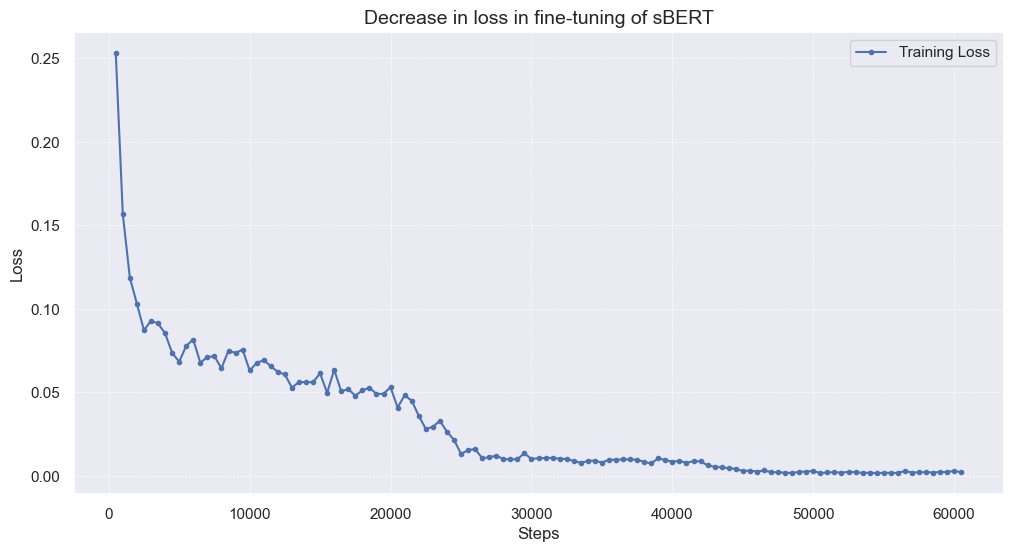

In [ ]:
steps = [
    500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500,
    7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500,
    13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000,
    18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500,
    24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000,
    29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500,
    35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000,
    40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500,
    46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000,
    51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500,
    57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500
]

losses = [
    0.253100, 0.156600, 0.118700, 0.103100, 0.087200, 0.092900, 0.091300,
    0.085400, 0.073700, 0.068400, 0.077900, 0.081700, 0.067800, 0.071200,
    0.071700, 0.064500, 0.075100, 0.073600, 0.075700, 0.063200, 0.067600,
    0.069400, 0.065700, 0.062300, 0.060800, 0.052900, 0.056200, 0.056200,
    0.056200, 0.061400, 0.049800, 0.063600, 0.050700, 0.052000, 0.048100,
    0.051200, 0.052900, 0.049100, 0.049200, 0.053200, 0.041000, 0.048300,
    0.045100, 0.036100, 0.028200, 0.029400, 0.033100, 0.026500, 0.021700,
    0.013300, 0.015400, 0.016200, 0.010700, 0.011200, 0.012200, 0.010200,
    0.009900, 0.010100, 0.013600, 0.010200, 0.010700, 0.010700, 0.010900,
    0.010300, 0.010200, 0.009000, 0.007900, 0.009000, 0.009200, 0.008000,
    0.009800, 0.009700, 0.010000, 0.009900, 0.009700, 0.008500, 0.007500,
    0.010700, 0.009500, 0.008600, 0.009100, 0.007900, 0.008900, 0.008800,
    0.006400, 0.005500, 0.005200, 0.004700, 0.004300, 0.003000, 0.003200,
    0.002700, 0.003300, 0.002400, 0.002200, 0.002000, 0.001800, 0.002500,
    0.002600, 0.003100, 0.001700, 0.002200, 0.002200, 0.002100, 0.002400,
    0.002400, 0.001800, 0.002000, 0.001700, 0.001900, 0.001900, 0.001800,
    0.003000, 0.002100, 0.002200, 0.002300, 0.002100, 0.002400, 0.002400,
    0.003100, 0.002200
]

matplotlib.pyplot.figure(figsize=(12, 6))
matplotlib.pyplot.plot(steps, losses, label="Training Loss", color='b', marker='o', markersize=3)
matplotlib.pyplot.title("Decrease in loss in fine-tuning of sBERT", fontsize=14)
matplotlib.pyplot.xlabel("Steps", fontsize=12)
matplotlib.pyplot.ylabel("Loss", fontsize=12)
matplotlib.pyplot.grid(True, which="both", linestyle='--', linewidth=0.5)
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

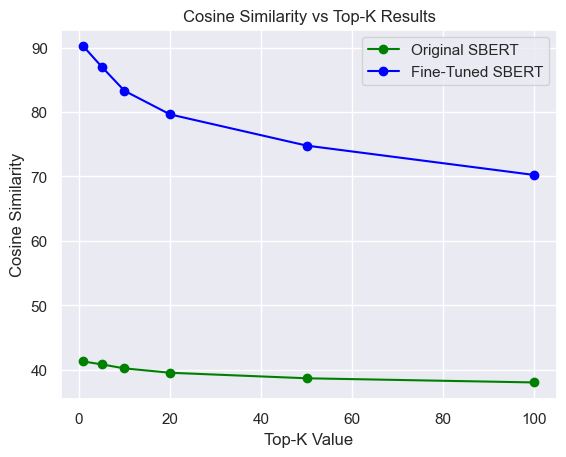

In [ ]:
def faiss_search_similarity_top_k(search_query, k_values, faiss_index, sbert_model):
    similarities = []

    for k in k_values:
        search_query_vector = sbert_model.encode([search_query])
        results = faiss_index.search(numpy.array(search_query_vector).astype('float32'), k)
        max_similarity = numpy.mean(results[0][0])
        similarities.append(max_similarity)

    return similarities

k_values = [1, 5, 10, 20, 50, 100]
search_query = "movie in which players are trapped in a game"

similarities_original = faiss_search_similarity_top_k(search_query, k_values, faiss_index, sbert_model)
similarities_fine_tuned = faiss_search_similarity_top_k(search_query, k_values, fine_tuned_faiss_index, fine_tuned_sbert_model)


matplotlib.pyplot.plot(k_values, similarities_original, marker='o', color='green', label="Original SBERT")
matplotlib.pyplot.plot(k_values, similarities_fine_tuned, marker='o', color='blue', label="Fine-Tuned SBERT")
matplotlib.pyplot.title("Cosine Similarity vs Top-K Results")
matplotlib.pyplot.xlabel("Top-K Value")
matplotlib.pyplot.ylabel("Cosine Similarity")
matplotlib.pyplot.grid(True)
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [ ]:
queries_with_matches = [
    ["man killed his wife", ["The Postman Always Rings Twice", "Gone Girl"]],
    ["pain of love", ["Romeo and Juliet", "The Notebook", "Eternal Sunshine of the Spotless Mind"]],
    ["girl did suicide", ["13 Reasons Why", "The Virgin Suicides", "A Star Is Born"]],
    ["AI takes over the world", ["The Terminator", "The Matrix", "Ex Machina"]],
    ["robbery gone wrong", ["Dog Day Afternoon", "Reservoir Dogs", "Inside Man"]],
    ["revenge of a betrayed hero", ["The Count of Monte Cristo", "Kill Bill", "Gladiator"]],
    ["mysterious disappearance", ["Gone Girl", "The Girl with the Dragon Tattoo", "Prisoners"]],
    ["family drama with secrets", ["August: Osage County", "Little Miss Sunshine", "The Royal Tenenbaums"]],
    ["fighting against racial injustice", ["To Kill a Mockingbird", "12 Years a Slave", "The Help"]],
    ["spaceship lost in space", ["Interstellar", "Gravity", "The Martian"]],
    ["unexpected inheritance", ["Knives Out", "The Grand Budapest Hotel", "The Inheritance"]],
    ["battle of wits", ["Sherlock Holmes", "The Prestige", "A Beautiful Mind"]],
    ["haunted by the past", ["Shutter Island", "The Sixth Sense", "The Others"]],
    ["children fighting evil", ["Harry Potter and the Sorcerer’s Stone", "Stranger Things", "The Goonies"]],
    ["lovers from different worlds", ["Titanic", "Aladdin", "Avatar"]],
    ["life after apocalypse", ["Mad Max: Fury Road", "The Road", "The Book of Eli"]],
    ["escaping from a prison", ["The Shawshank Redemption", "Escape Plan", "Papillon"]],
    ["hero turned villain", ["Star Wars: Revenge of the Sith", "Breaking Bad", "Joker"]],
    ["sacrificing for a greater cause", ["The Hunger Games", "Schindler’s List", "The Dark Knight"]],
    ["man lost in time", ["Back to the Future", "The Time Traveler's Wife", "Doctor Who"]],
    ["survival against nature", ["Cast Away", "127 Hours", "The Revenant"]],
    ["monster terrorizing a town", ["Jaws", "It", "King Kong"]],
    ["world on the brink of war", ["Dr. Strangelove", "War Games", "Crimson Tide"]],
    ["redemption of a criminal", ["American History X", "Les Misérables", "The Equalizer"]],
    ["fighting corruption", ["Erin Brockovich", "Serpico", "The Departed"]],
    ["love triangle drama", ["Twilight", "Casablanca", "The Great Gatsby"]],
    ["dealing with mental illness", ["Silver Linings Playbook", "A Beautiful Mind", "Girl, Interrupted"]],
    ["alien invasion", ["Independence Day", "Arrival", "War of the Worlds"]],
    ["rebellion against tyranny", ["The Hunger Games", "Braveheart", "V for Vendetta"]],
    ["treasure hunt adventure", ["Indiana Jones", "National Treasure", "Pirates of the Caribbean"]],
    ["adventure in a magical land", ["The Chronicles of Narnia", "Alice in Wonderland", "The Wizard of Oz"]],
    ["life of a struggling artist", ["La La Land", "Frida", "Moulin Rouge!"]],
    ["warrior seeking honor", ["Mulan", "300", "The Last Samurai"]],
    ["city under siege", ["Black Hawk Down", "Dunkirk", "Children of Men"]],
    ["forbidden love", ["West Side Story", "Brokeback Mountain", "Romeo and Juliet"]],
    ["man searching for his family", ["Finding Nemo", "Taken", "Life is Beautiful"]],
    ["friendship overcoming challenges", ["The Lord of the Rings", "Thelma & Louise", "Stand by Me"]],
    ["rise of a sports legend", ["Rocky", "Creed", "Rudy"]],
    ["childhood innocence", ["The Boy in the Striped Pajamas", "My Girl", "The Sandlot"]],
    ["deadly survival game", ["The Hunger Games", "Squid Game", "Battle Royale"]],
    ["genius misunderstood by society", ["Good Will Hunting", "The Social Network", "The Imitation Game"]],
    ["sibling rivalry", ["Thor", "East of Eden", "The Fighter"]],
    ["journey to find oneself", ["Eat Pray Love", "Wild", "The Secret Life of Walter Mitty"]],
    ["a secret affair", ["The Bridges of Madison County", "Unfaithful", "The English Patient"]],
    ["childhood friends reuniting", ["It", "Now and Then", "Stand by Me"]],
    ["living in isolation", ["Cast Away", "Room", "The Lighthouse"]],
    ["ghost seeking revenge", ["The Ring", "The Grudge", "Crimson Peak"]],
    ["hidden identity revealed", ["The Prestige", "The Bourne Identity", "V for Vendetta"]],
    ["overcoming addiction", ["Requiem for a Dream", "Trainspotting", "A Star Is Born"]],
    ["quest for a lost treasure", ["The Mummy", "Indiana Jones", "Uncharted"]],
    ["rising against a dictator", ["The Great Dictator", "1984", "Braveheart"]],
    ["child prodigy", ["Searching for Bobby Fischer", "August Rush", "Little Man Tate"]],
    ["lives intertwined by fate", ["Crash", "Cloud Atlas", "Babel"]],
    ["traveling through time", ["Looper", "About Time", "Timecrimes"]],
    ["adopted child finding real parents", ["The Blind Side", "Lion", "Kung Fu Panda"]],
    ["robots with emotions", ["Wall-E", "A.I. Artificial Intelligence", "Bicentennial Man"]],
    ["racing to save the world", ["Mission: Impossible", "Armageddon", "The Day After Tomorrow"]],
    ["living with a terminal illness", ["The Fault in Our Stars", "Me Before You", "A Walk to Remember"]],
    ["vampire love story", ["Twilight", "Interview with the Vampire", "Let the Right One In"]],
    ["escaping a dangerous cult", ["Midsommar", "The Wicker Man", "The Master"]],
    ["chasing a serial killer", ["Se7en", "Zodiac", "The Silence of the Lambs"]],
    ["struggling during war", ["The Pianist", "Life is Beautiful", "The Boy in the Striped Pajamas"]],
    ["misfit group saves the day", ["Guardians of the Galaxy", "The Suicide Squad", "The Goonies"]],
    ["fall of an empire", ["Gladiator", "The Last Emperor", "Troy"]],
    ["small town secrets", ["Twin Peaks", "Fargo", "Mystic River"]],
    ["investigating a conspiracy", ["All the President’s Men", "The Parallax View", "Spotlight"]],
    ["animal saving humans", ["Free Willy", "Lassie", "Dolphin Tale"]],
    ["battle for a throne", ["Game of Thrones", "The Lion King", "The King"]],
    ["scientist unleashes chaos", ["Jurassic Park", "Frankenstein", "Spider-Man 2"]],
    ["trapped in a game", ["Jumanji", "Tron", "Ready Player One"]]
]

for row in queries_with_matches:
        cleaned_movies_list = []
        for movie in row[1]:
            cleaned_string = ""
            for char in movie:
                if char not in string.punctuation:
                    if char != " ":
                        cleaned_string += char.lower()
            cleaned_movies_list.append(cleaned_string)
        row.append(cleaned_movies_list)


models = ['bert','bge','snowflake','sbert','sbert_with_faiss','fine_tuned_sbert_with_faiss']
model_counts = []
for model in models:
    count = 0
    for query in queries_with_matches:
        results = search_movies_articles(query[0], model,10)
        results = results["title"].tolist()
        for movie in query[2]:
            for result in results:
                cleaned_string = ""
                for char in result:
                    if char not in string.punctuation:
                        if char != " ":
                            cleaned_string += char.lower()
                if movie in cleaned_string:
                    count += 1
                    break
    model_counts.append(count)

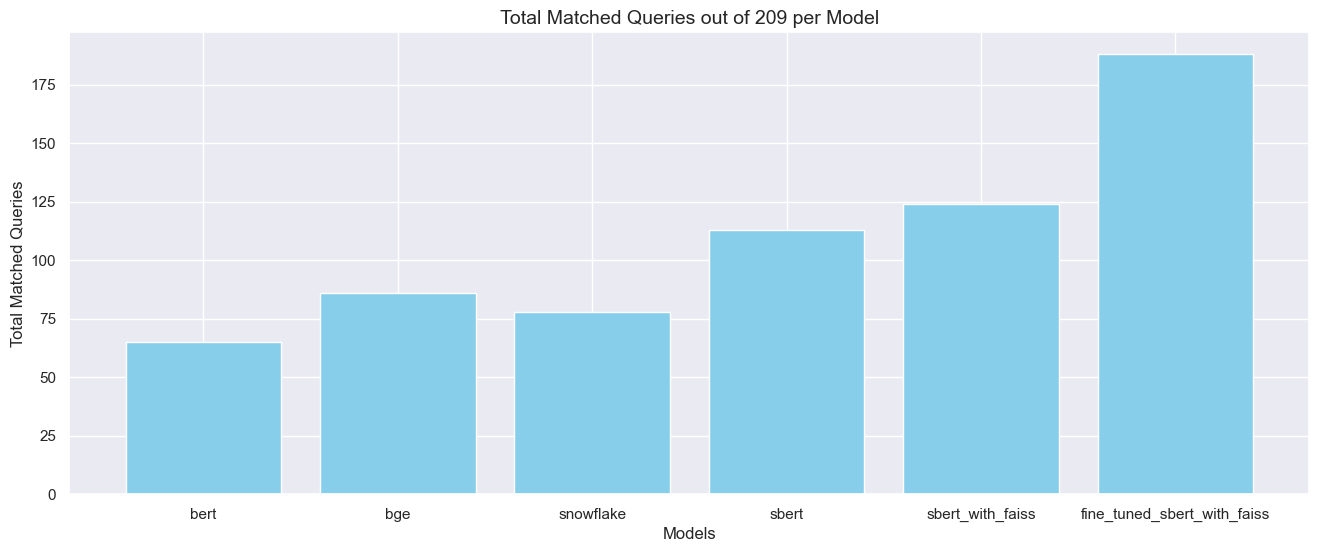

In [ ]:
full_name_models = ['BERT', 'BGE', 'Snowflake', 'SBERT', 'Fine-Tuned BERT', 'Fine-Tuned SBERT']

matplotlib.pyplot.figure(figsize=(16, 6))
matplotlib.pyplot.bar(models, model_counts, color='skyblue')

matplotlib.pyplot.title('Total Matched Queries out of 209 per Model', fontsize=14)
matplotlib.pyplot.xlabel('Models', fontsize=12)
matplotlib.pyplot.ylabel('Total Matched Queries', fontsize=12)

matplotlib.pyplot.show()